Classification Problem
https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501

- Logistic 


In [25]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dython.nominal import identify_nominal_columns, associations

root_dir = "input"

In [26]:
# Show me what we have
os.listdir(root_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [27]:
# Load all the data
df_train = pd.read_csv(root_dir + "/train.csv")
df_test = pd.read_csv(root_dir + "/test.csv")
df_sample = pd.read_csv(root_dir + "/sample_submission.csv")


In [32]:
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

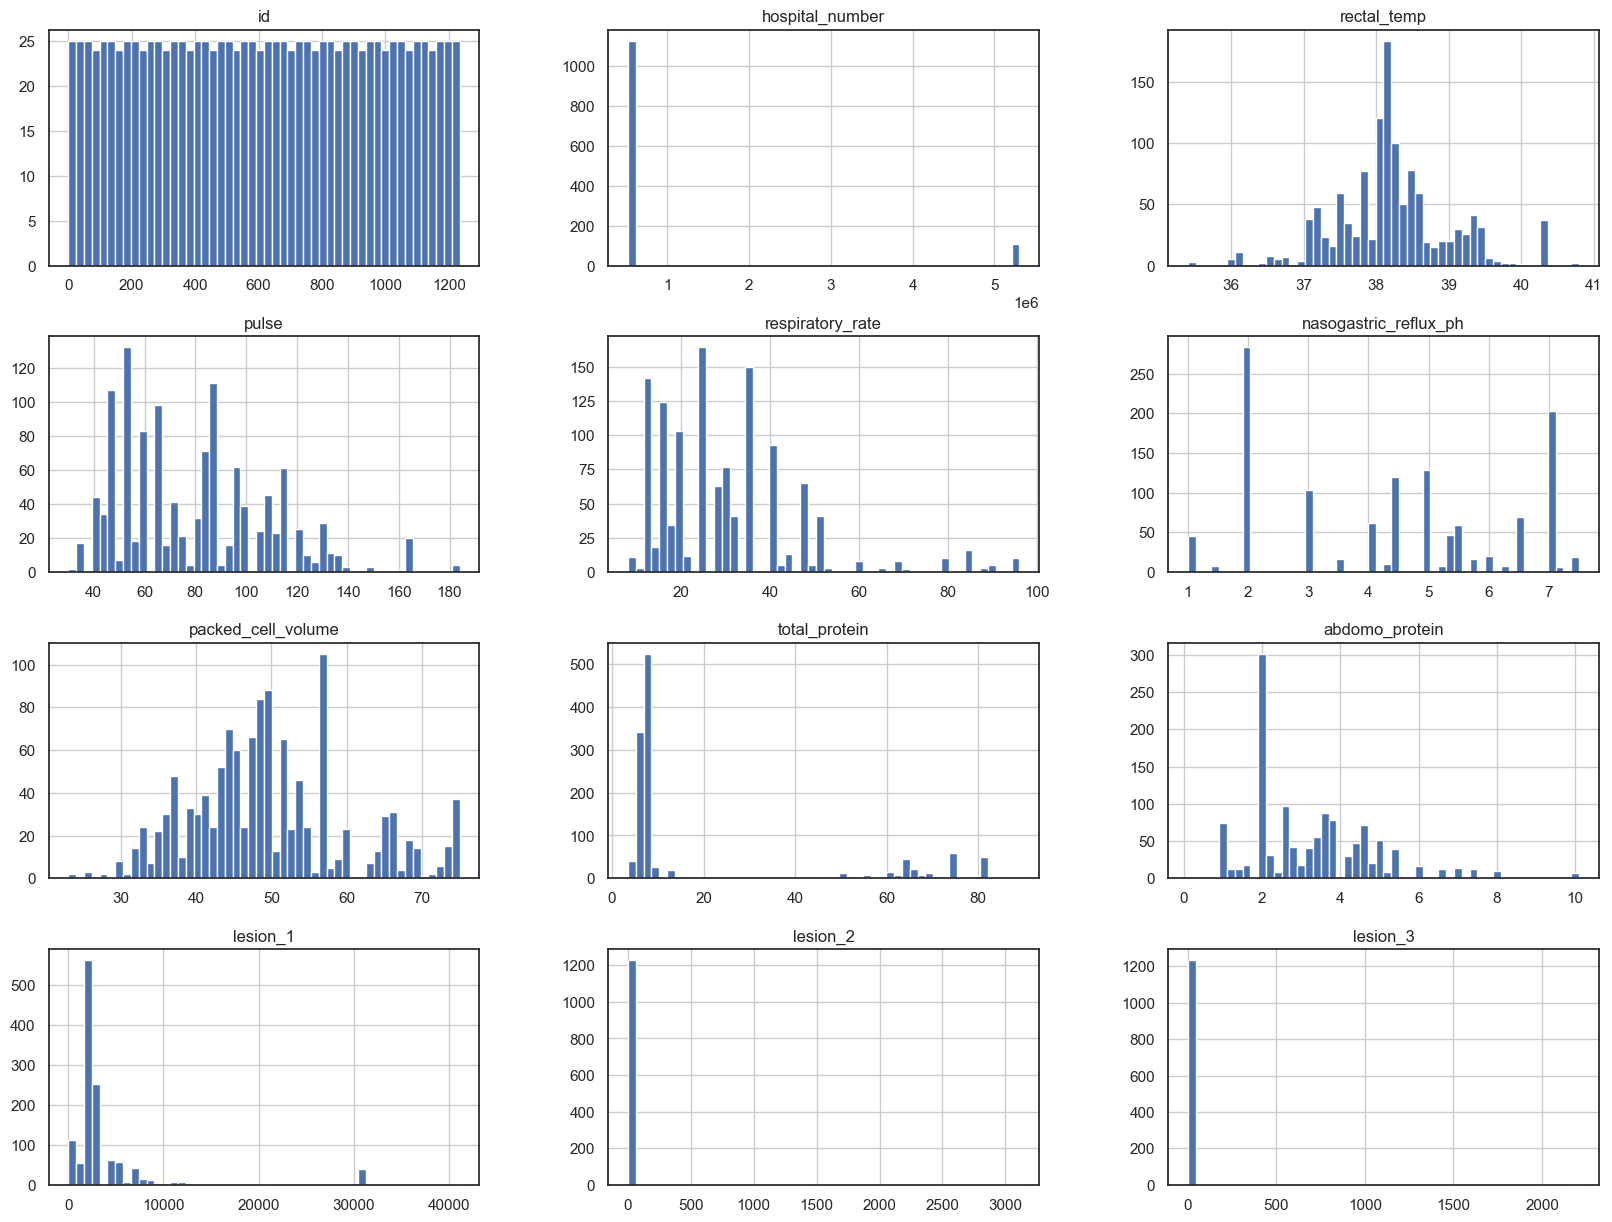

In [33]:
# only float values
df_train.hist(bins=50, figsize=(20,15))
plt.show()

array([[<Axes: xlabel='id', ylabel='id'>,
        <Axes: xlabel='hospital_number', ylabel='id'>,
        <Axes: xlabel='rectal_temp', ylabel='id'>,
        <Axes: xlabel='pulse', ylabel='id'>,
        <Axes: xlabel='respiratory_rate', ylabel='id'>,
        <Axes: xlabel='nasogastric_reflux_ph', ylabel='id'>,
        <Axes: xlabel='packed_cell_volume', ylabel='id'>,
        <Axes: xlabel='total_protein', ylabel='id'>,
        <Axes: xlabel='abdomo_protein', ylabel='id'>,
        <Axes: xlabel='lesion_1', ylabel='id'>,
        <Axes: xlabel='lesion_2', ylabel='id'>,
        <Axes: xlabel='lesion_3', ylabel='id'>],
       [<Axes: xlabel='id', ylabel='hospital_number'>,
        <Axes: xlabel='hospital_number', ylabel='hospital_number'>,
        <Axes: xlabel='rectal_temp', ylabel='hospital_number'>,
        <Axes: xlabel='pulse', ylabel='hospital_number'>,
        <Axes: xlabel='respiratory_rate', ylabel='hospital_number'>,
        <Axes: xlabel='nasogastric_reflux_ph', ylabel='hospital_nu

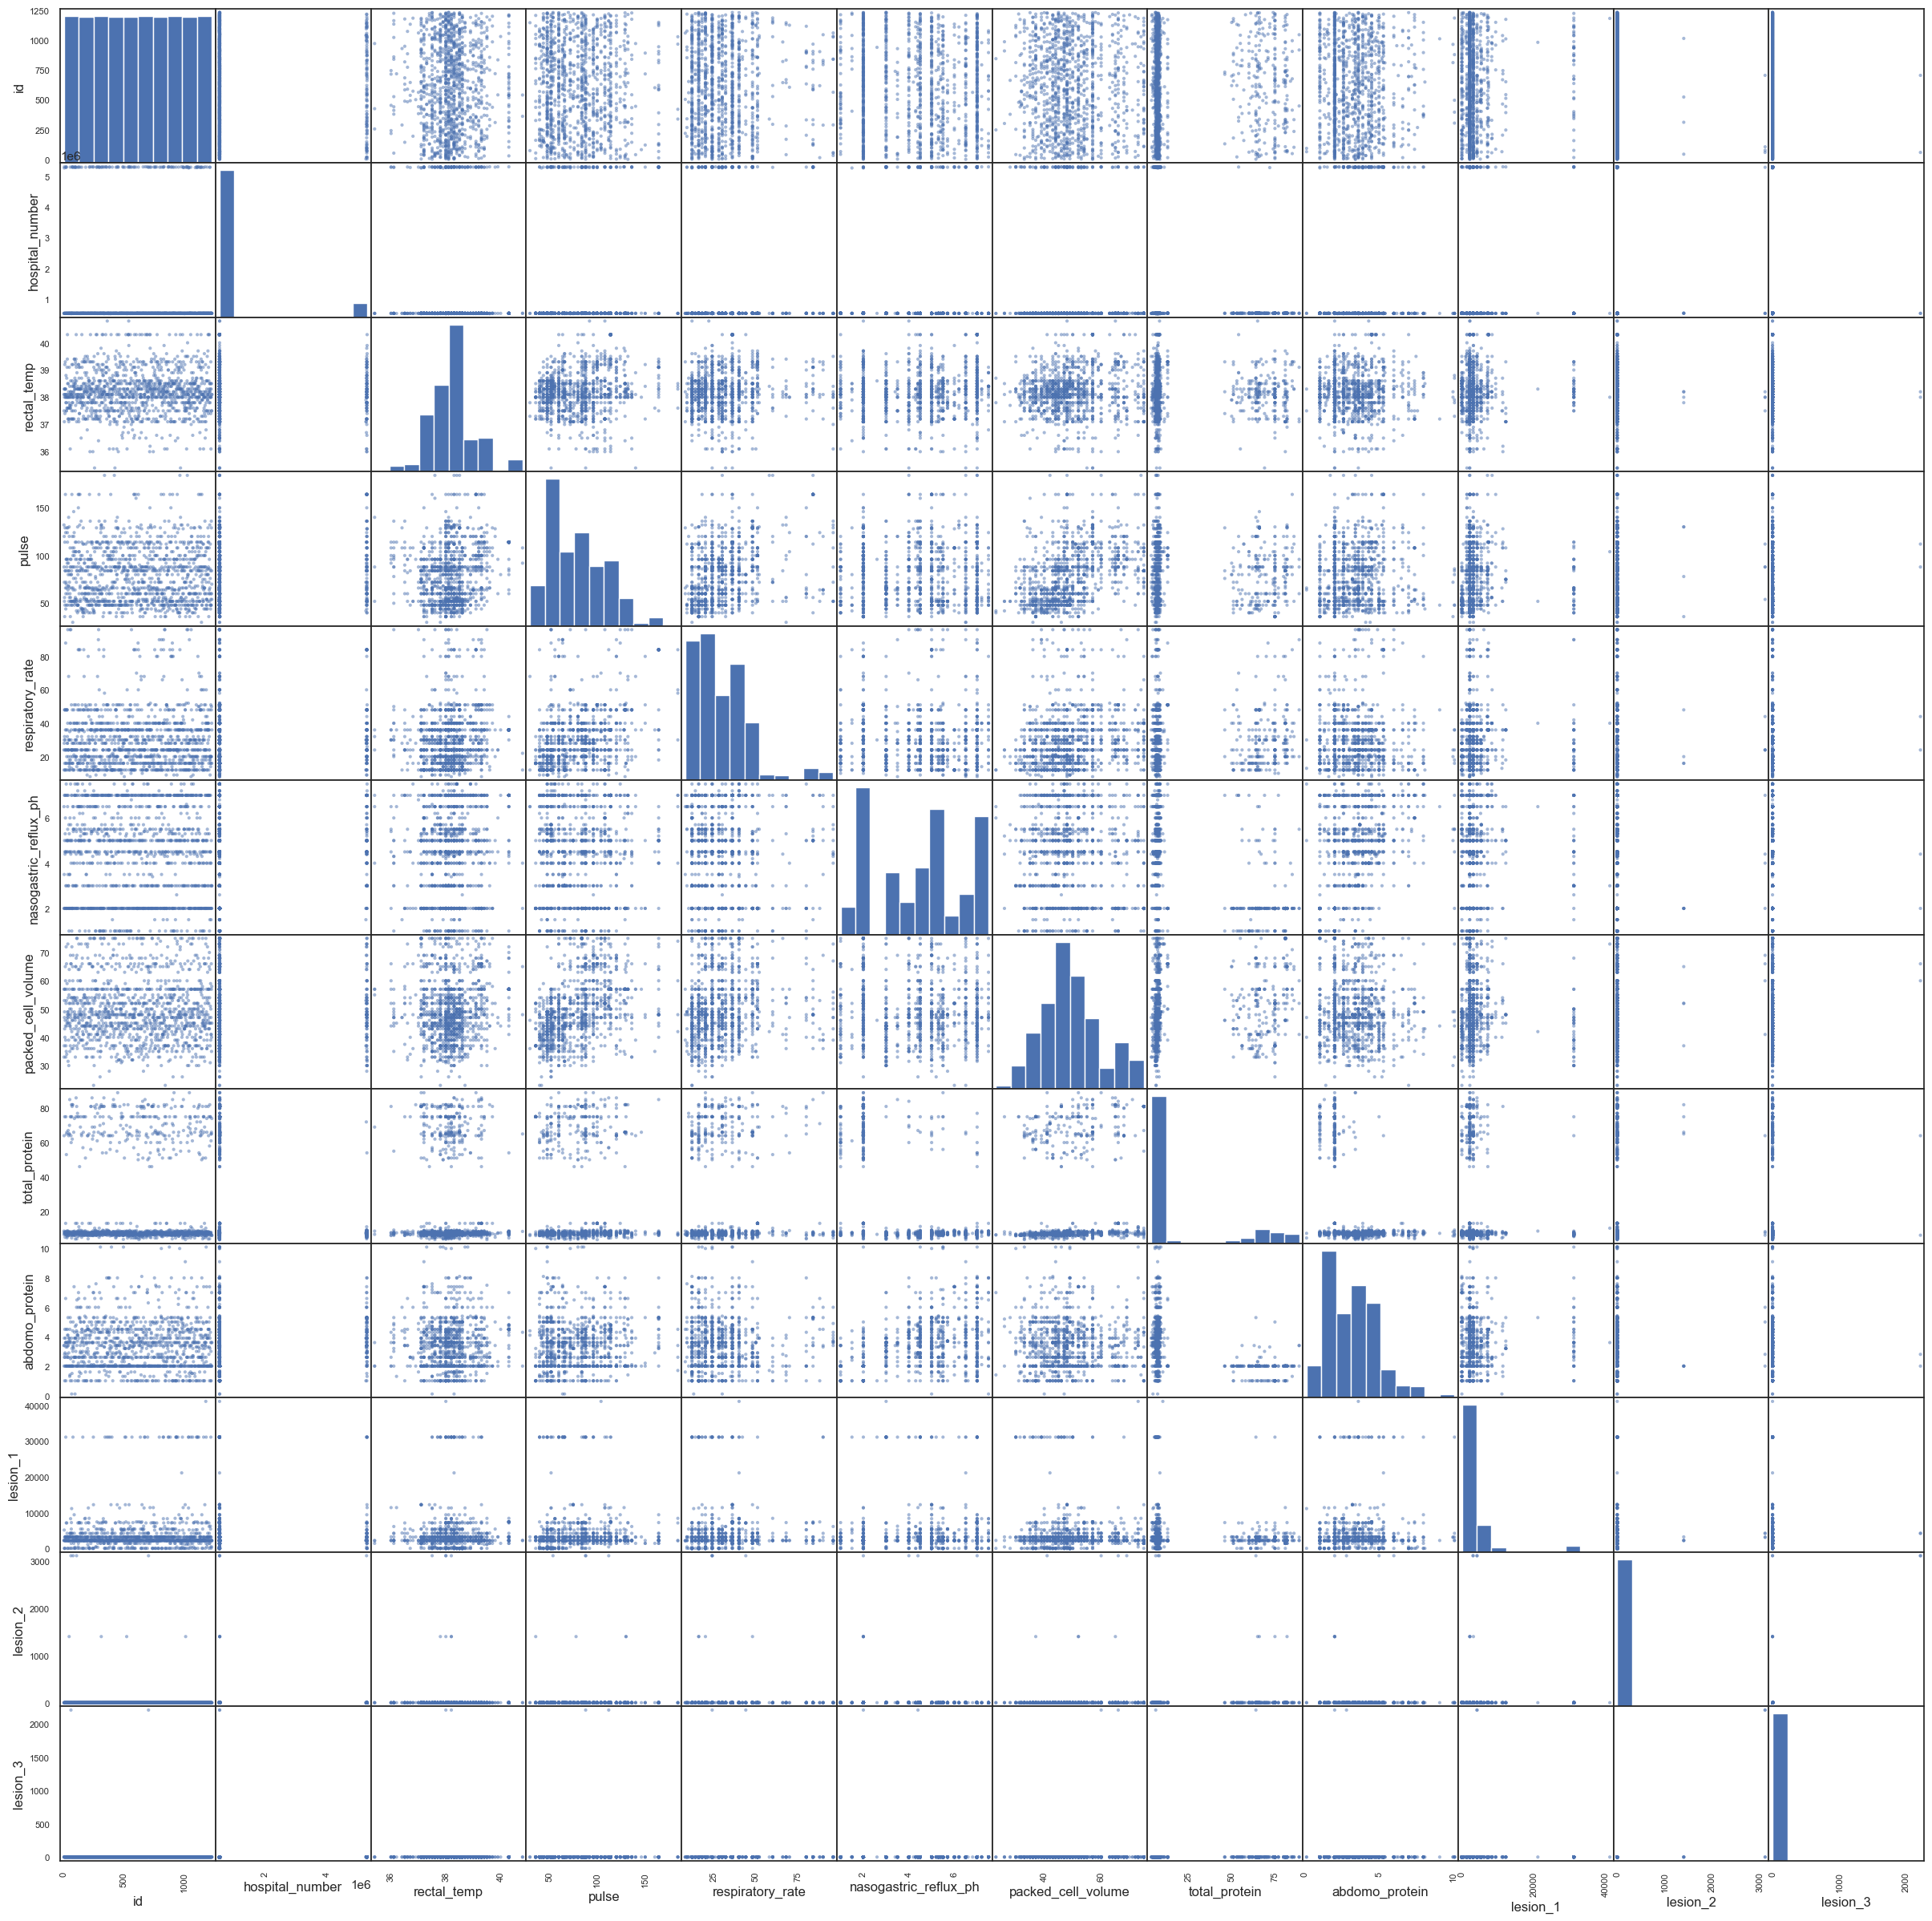

In [35]:
pd.plotting.scatter_matrix(df_train, figsize=(30,30))

In [ ]:
# Hist also for the categories
# Plot interesting features together (from correlation plot)
# Delete NaN values
# delete zeros values


Now start to understand the columns and the data.

What is normal for a horse?
https://canberraequinehospital.com.au/vital-signs-adult-horse/

- Heart rate 38-44 beats per minute
- Rectal temperature 37-38.5ºC
- Respiratory (breathing) rate 12-20 breaths per minute
- Gums should be light pink and moist, and capillary refill time less than 2 seconds
- Sounds of the intestines should be heard on both sides of the abdomen
- 6-10 manures and 3-4 urinations should be passed every 24 hours
- A 500kg thoroughbred-sized horse drinks 20-25 litres every 24 hours


https://www.midcoastequine.com/normal-vital-signs
Addult: Heart Rate 28-44, Respiratory 10-24
Foals: Heart Rate 80-100 bpm, Respiratory 20-40bpm



c:\Users\gorge\anaconda3\envs\py39\lib\site-packages\dython\nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
c:\Users\gorge\anaconda3\envs\py39\lib\site-packages\dython\nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


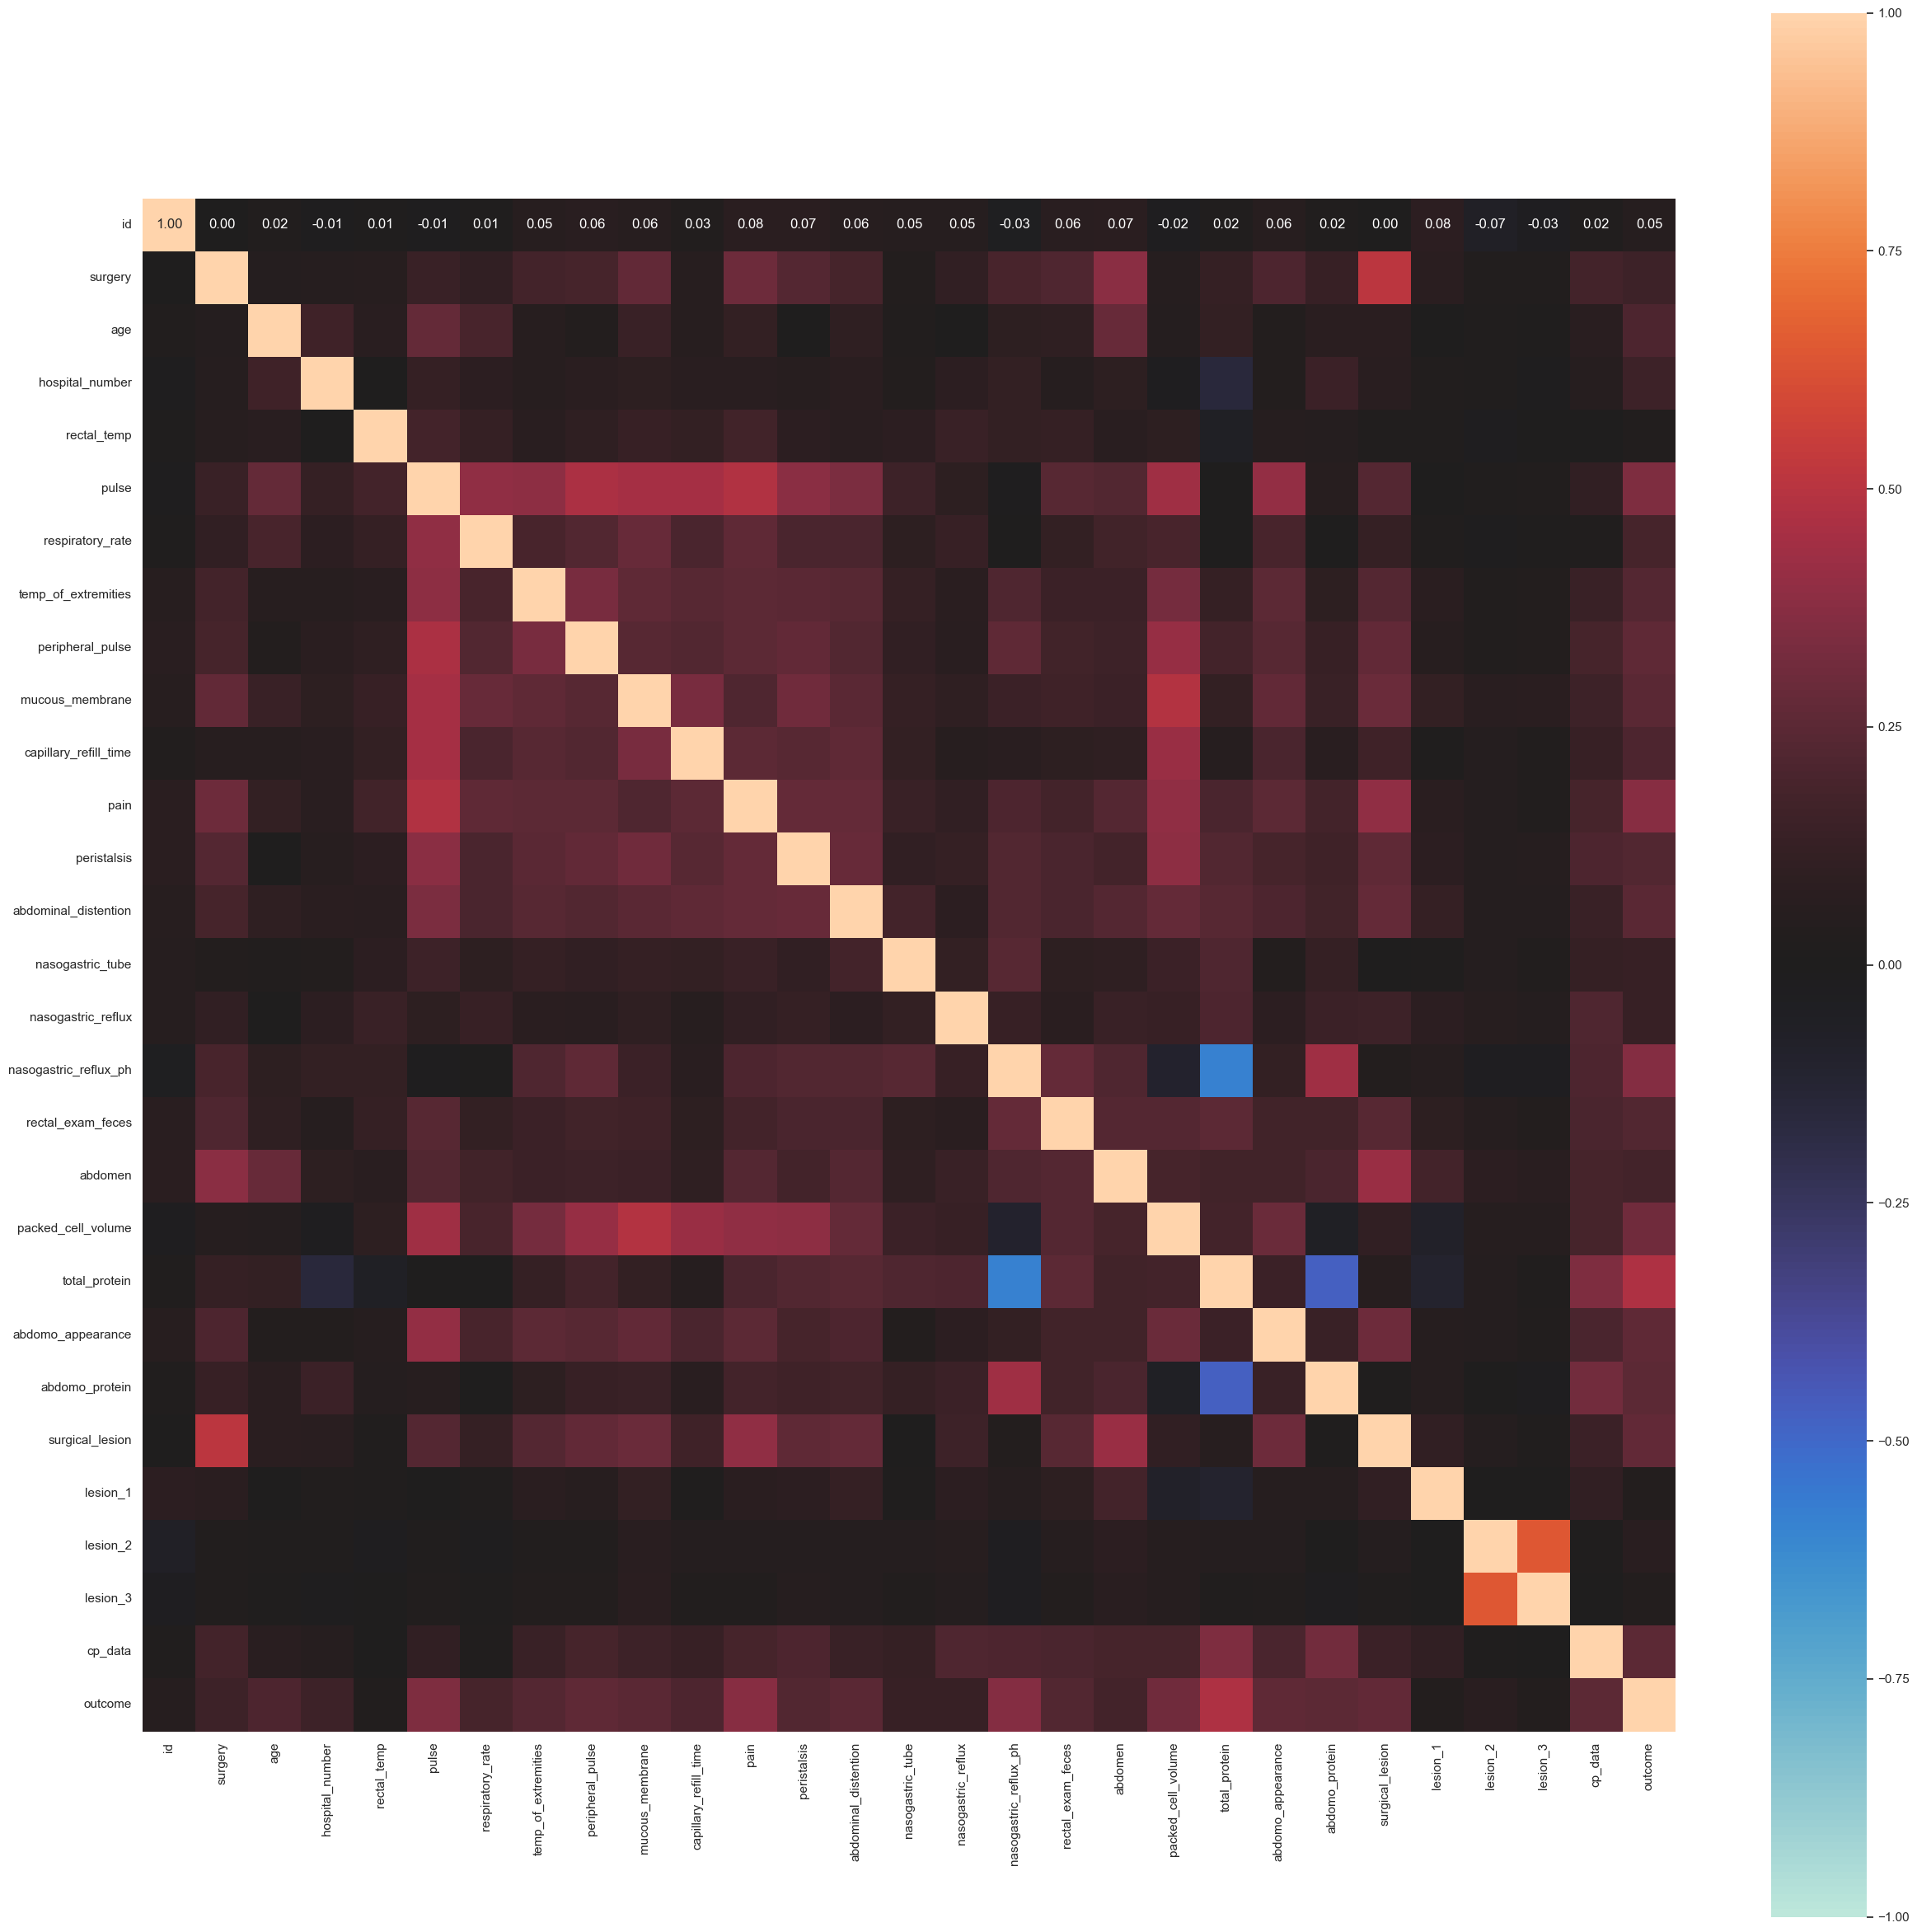

In [28]:
# Fast Correleation matrix 
categorical_features=identify_nominal_columns(df_train)
complete_correlation= associations(df_train, figsize=(30,30))